# Collaborative filtering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as scsp

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Display
import ipywidgets as w
from ipywidgets import widgets, HBox, VBox
from IPython.core.display import HTML
from movie_display import movie_display

app = w.Output()

## Analyzing the given ratings dataset
Show graphs in which the characteristics of the ratings are shown:
1. Distribution of how often a movie is rated
2. Distribution of how often a specific rating was given
3. Distribution of the average ratings given to a movie
4. Distribution of the average ratings given by the users
5. Something you want to learn from the data set

The following files are going to be used for plotting these graphs:
- Movie info: `movies.csv`
  - `movieId, title, genres`
- Movie ratings by users: `ratings.csv`
  - `userId, movieId, rating, timestamp`

In [2]:
movies = pd.read_csv('./dataset/movies.csv')
ratings = pd.read_csv('./dataset/ratings.csv')
test_ratings = pd.read_csv('./dataset/test.csv')

In [3]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [4]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182


In [5]:
test_ratings

,userId,movieId,rating
0,1,1,4.0
1,1,4,5.0
2,1,5,1.0
3,2,1,5.0
4,2,2,5.0
5,2,3,4.0
6,3,4,2.0
7,3,5,4.0
8,3,6,5.0
9,4,2,3.0


### 1. Distribution of how often a movie is rated

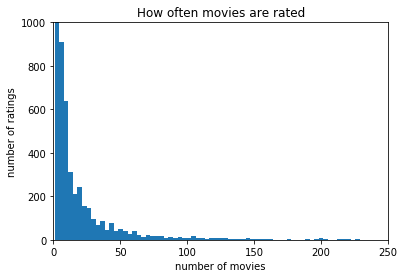

In [6]:
rate_count = ratings[['movieId', 'rating']].groupby('movieId').count()
_ = rate_count.plot.hist(bins=100, title='How often movies are rated', xlim=(0, 250), ylim=(0, 1000), legend=False).set(xlabel='number of movies', ylabel='number of ratings')

##### Conclusion
We can see in this graph that only a small amount of movies has a lot of ratings and as we go along the x-axis the amount of ratings decreases. We can state that most of the movies aren't rated. 

### 2. Distribution of how often a specific rating was given

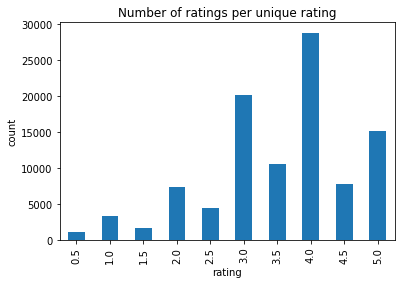

In [7]:
specific_rate_count = ratings[['rating', 'movieId']].groupby('rating').count()
_ = specific_rate_count.plot(kind='bar', title='Number of ratings per unique rating', legend=False).set_ylabel('count')

##### Conclusion
We can see in this graph that giving a round numbered rating is more common than rating with decimals. We can also state that most of the ratings are between 3 and 5. 

### 3. Distribution of the average ratings given to a movie

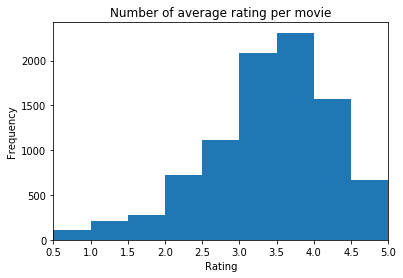

In [8]:
avg_movie_ratings = ratings[['movieId', 'rating']].groupby('movieId').mean()
_ = avg_movie_ratings.plot.hist(bins=9, xlim=(0.5, 5), title='Number of average rating per movie', legend=False).set_xlabel('Rating')

##### Conclusion
This graph shows that a movie's average rating of 3.5 - 4.0 occurs most.

### 4. Distribution of the average ratings given by the users

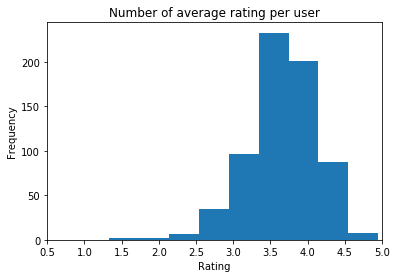

In [9]:
avg_user_ratings = ratings[['userId', 'rating']].groupby('userId').mean()
_ = avg_user_ratings.plot.hist(bins=9, xlim=(0.5, 5), title='Number of average rating per user', legend=False).set_xlabel('Rating')

##### Conclusion
This graph shows us that most users mostly rate movies they like because most of the average ratings are above 3.

## User-item & item-user matrices

A table with every rating from every user for every movie.

```
user-item structure:
   /      movieids
userids   ratings

item-user structure:
   /      userids
movieids  ratings

user-item example:
   /      1,   2,   3
   1      0.5  4.0  0.0
   2      0.0  1.0  2.5
   3      1.5  5.0  3.5
```

In the example above, user 0 rated movie 0 with 0.5 (stars) and user 2 rated movie 1 with 5 (starts).

We use a dataframe because the movie ids and indices don't match. Creating the dataframe is done using a simple pivot of the linear data provided.

In [10]:
user_item_df = ratings.pivot(index='userId', columns='movieId', values='rating')
user_item_df.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
item_user_df = ratings.pivot(index='movieId', columns='userId', values='rating')
item_user_df.head(10)

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## User-user matrix

A table with the similiarity of every user to every user.

We derive user-user similarity matrices based on thee metrics:

1. Cosine similarity
2. Pearson similarity
3. Adjusted cosine similarity

Note:

- Because every user is perfectly similar to themselves, a diagonal line of 'perfect' `1.0` scores occurs from the top left to the bottom right.

### 1. Cosine similarity

Cosine angle distance between items. `0.0 - 1.0`

Except for filling all NaNs with 0, the data needs no preparation to calculate the cosine similarity.

In [12]:
cosine_user_user_df = pd.DataFrame(cosine_similarity(user_item_df.fillna(0)), 
                                    index=user_item_df.index, 
                                    columns=user_item_df.index)
cosine_user_user_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.074482,0.016818,0.000000,0.083884,0.000000,0.012843,0.000000,...,0.000000,0.000000,0.014474,0.043719,0.000000,0.000000,0.000000,0.062917,0.000000,0.017466
2,0.000000,1.000000,0.124295,0.118821,0.103646,0.000000,0.212985,0.113190,0.113333,0.043213,...,0.477306,0.063202,0.077745,0.164162,0.466281,0.425462,0.084646,0.024140,0.170595,0.113175
3,0.000000,0.124295,1.000000,0.081640,0.151531,0.060691,0.154714,0.249781,0.134475,0.114672,...,0.161205,0.064198,0.176134,0.158357,0.177098,0.124562,0.124911,0.080984,0.136606,0.170193
4,0.074482,0.118821,0.081640,1.000000,0.130649,0.079648,0.319745,0.191013,0.030417,0.137186,...,0.114319,0.047228,0.136579,0.254030,0.121905,0.088735,0.068483,0.104309,0.054512,0.211609
5,0.016818,0.103646,0.151531,0.130649,1.000000,0.063796,0.095888,0.165712,0.086616,0.032370,...,0.191029,0.021142,0.146173,0.224245,0.139721,0.058252,0.042926,0.038358,0.062642,0.225086


### 2. Pearson similarity

Cosine angle distance between items. `-1.0 - 1.0`

Values are first centered around zero by subtracting the row average from it.

In [13]:
_c = user_item_df.copy()

centered_user_item_df = _c.subtract(user_item_df.mean(axis=1), axis=0).fillna(0)

centered_user_item_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.513158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,-0.348039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.09,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
pearson_user_user_df = pd.DataFrame(cosine_similarity(centered_user_item_df), 
                                    index=user_item_df.index, 
                                    columns=user_item_df.index)
pearson_user_user_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.003620,-0.002274,0.000000,-0.070321,0.000000,0.042632,0.000000,...,0.000000,0.000000,0.018643,0.001031,0.000000,0.000000,0.000000,0.044095,0.000000,-0.013096
2,0.000000,1.000000,-0.001852,-0.004854,0.012639,0.000000,0.042691,0.021066,0.011109,-0.007989,...,-0.018248,-0.021546,0.018902,-0.058952,0.028515,-0.106828,-0.007999,-0.041628,-0.090233,0.056258
3,0.000000,-0.001852,1.000000,0.018594,-0.025903,-0.063200,0.054900,0.026488,-0.036187,0.038021,...,0.044297,0.019581,0.070702,0.030669,0.143705,0.096713,0.027451,0.089297,-0.009815,0.062276
4,0.003620,-0.004854,0.018594,1.000000,0.010801,0.019224,0.057519,0.055430,-0.010442,0.005126,...,0.011978,0.006569,0.027687,0.092092,0.021334,0.040833,0.018428,0.028642,0.019848,0.032749
5,-0.002274,0.012639,-0.025903,0.010801,1.000000,-0.005843,-0.015075,-0.038886,0.013708,0.030500,...,0.046134,0.001903,0.001620,0.036819,-0.038269,-0.019537,-0.071721,0.003760,-0.029455,-0.036814


### 3. Adjusted cosine similarity

Cosine angle distance between items. `-1.0 - 1.0`

Values are first centered around zero by subtracting the column average from it.

In [15]:
_c = user_item_df.copy()

centered_item_user_df = _c[_c > 0].subtract(user_item_df.mean(axis=0), axis=1).fillna(0)

centered_item_user_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.54918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.54918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.838983,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
adj_cosine_user_user_df = pd.DataFrame(cosine_similarity(centered_item_user_df), 
                                    index=user_item_df.index, 
                                    columns=user_item_df.index)
adj_cosine_user_user_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,-0.042928,-0.020326,0.000000,-0.084835,0.000000,0.056693,0.000000,...,0.000000,0.000000,0.001404,0.002595,0.000000,0.000000,0.000000,0.000023,0.000000,0.021158
2,0.000000,1.000000,0.026386,-0.018799,0.014673,0.000000,0.040012,-0.022239,0.001264,-0.023076,...,-0.011616,0.006937,0.002182,-0.062952,-0.079717,-0.147949,-0.042216,-0.011552,-0.115512,0.042947
3,0.000000,0.026386,1.000000,-0.017612,-0.030283,-0.040315,-0.028884,-0.029348,-0.054177,-0.006088,...,-0.055113,0.007258,-0.011623,-0.032968,0.194814,0.046531,-0.057462,0.103936,-0.040322,-0.001326
4,-0.042928,-0.018799,-0.017612,1.000000,0.023250,0.008572,-0.046809,0.004820,-0.012379,-0.031362,...,-0.024827,-0.007848,0.022981,0.028751,-0.034598,0.005869,-0.000343,-0.010801,0.011823,0.027860
5,-0.020326,0.014673,-0.030283,0.023250,1.000000,0.010561,-0.021507,-0.011979,-0.006786,0.038089,...,0.025104,0.000131,0.049178,0.065194,-0.051955,-0.022723,-0.058358,0.037019,0.001900,-0.017869


## Recommend Movies Using Similiar Users

Looking up `user_user_df.loc[user_id]` gives the similiarities for that user to all users.

### `get_similar_users(user_user_df, user_id, n_users=10)`

Get the `n_users` most similar users according to the provided user-user dataframe including the provided `user_id` in the first position.

### `recommend_movies(user_item_df, user_ids, n_movies=10)`

Recommending movies works by adding all movies the similar users have rated to a set and subtracting the movies the user has already seen from it. What's left is reverse sorted on rating given by these similar users.

Return the movie ids and rankings of the recommendations.

### `recommend_user_user(user_user_df, user_item_df, user_id, n_users=10, n_movies=10)`

Both above steps in one.

In [17]:
def get_similar_users(user_user_df, user_id, n_users=10):
    """
    Get the n_users most similar users according to the provided user-user-df.
    Returned list includes the user_id provided.
    """
    return user_user_df.loc[user_id].nlargest(n_users + 1).index

def recommend_movies(user_item_df, user_ids, n_recommendations=10):
    """
    
    """
    user_id = user_ids[0]
    similar_user_ids = user_ids[1:]
    similar_df = user_item_df.loc[user_ids]
    movie_ids = set()
    # Add the movies other similar users have seen to the set
    for u_id in similar_user_ids:
        movie = similar_df.loc[u_id][similar_df.loc[u_id].notna()]
        movie_ids.update(zip(movie.index, movie.values))
    # Remove the movies the user has already seen from the set
    user_movies = similar_df.loc[user_id][similar_df.loc[user_id].notna()]
    for t in zip(user_movies.index, user_movies.values):
        movie_ids.discard(t)
    # Sort the movie tuples on their rankings so we recommend the movies that other similar users have rated highest
    return sorted(list(movie_ids), key=lambda x: x[1], reverse=True)[:n_recommendations]

def recommend_user_user(user_user_df, user_item_df, user_id, n_users=10, n_recommendations=10):
    su = get_similar_users(user_user_df, user_id, n_users)
    return recommend_movies(user_item_df, su, n_recommendations)


In [18]:
similar_users = get_similar_users(user_user_df=pearson_user_user_df, user_id=8)
similar_users

Int64Index([8, 588, 292, 627, 520, 94, 144, 461, 216, 521, 183], dtype='int64', name='userId')

In [19]:
recommend_movies(user_item_df=user_item_df, user_ids=similar_users)

[(7147, 5.0),
 (1203, 5.0),
 (1213, 5.0),
 (5669, 5.0),
 (10, 5.0),
 (593, 5.0),
 (8622, 5.0),
 (59784, 5.0),
 (2360, 5.0),
 (1208, 5.0)]

In [20]:
rm = recommend_user_user(user_user_df=pearson_user_user_df, user_item_df=user_item_df, user_id=8)
movies[movies.movieId.isin([m[0] for m in rm])]

,movieId,title,genres
9,10,GoldenEye (1995),Action|Adventure|Thriller
525,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
960,1203,12 Angry Men (1957),Drama
964,1208,Apocalypse Now (1979),Action|Drama|War
969,1213,Goodfellas (1990),Crime|Drama
1870,2360,"Celebration, The (Festen) (1998)",Drama
4259,5669,Bowling for Columbine (2002),Documentary
5021,7147,Big Fish (2003),Drama|Fantasy|Romance
5480,8622,Fahrenheit 9/11 (2004),Documentary
6966,59784,Kung Fu Panda (2008),Action|Animation|Children|Comedy|IMAX


## Item-item collaborative filtering

1. Take the K highest rated items of a user
2. Find L similar items
  - This is a pre-selection of movies that will probably have high predicted ratings. We don't want to recommend low predicted ratings anyway.
3. For each similar item that has not been seen by the user, calculate the expected rating (Weighted arithmetic mean)
4. Select the top N movies with the highest rating

Note: let L be much larger than N.

### Item-item Cosine, Pearson, Adjusted cosine similarity matrices

The three different similarity matrices are calculated in the exact same way as the user-user matrices but instead using the item-user dataframe.

In [21]:
cosine_item_item_df = pd.DataFrame(cosine_similarity(item_user_df.fillna(0)), 
                                   index=item_user_df.index, 
                                   columns=item_user_df.index)
cosine_item_item_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.394511,0.306516,0.133614,0.245102,0.377086,0.278629,0.063031,0.117499,0.310689,...,0.055829,0.031902,0.079755,0.079755,0.079755,0.079755,0.079755,0.0,0.0,0.055829
2,0.394511,1.000000,0.217492,0.164651,0.278476,0.222003,0.207299,0.223524,0.113669,0.418124,...,0.000000,0.055038,0.068797,0.082557,0.082557,0.137594,0.068797,0.0,0.0,0.000000
3,0.306516,0.217492,1.000000,0.177012,0.370732,0.247499,0.435648,0.127574,0.306717,0.191255,...,0.000000,0.000000,0.000000,0.116226,0.116226,0.000000,0.000000,0.0,0.0,0.000000
4,0.133614,0.164651,0.177012,1.000000,0.179556,0.072518,0.184626,0.501513,0.254630,0.111447,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
5,0.245102,0.278476,0.370732,0.179556,1.000000,0.272645,0.388476,0.194113,0.367941,0.246846,...,0.000000,0.176845,0.000000,0.117897,0.117897,0.000000,0.000000,0.0,0.0,0.000000


In [22]:
_c = item_user_df.copy()
centered_item_item_df = _c.subtract(item_user_df.mean(axis=1), axis=0).fillna(0)
pearson_item_item_df = pd.DataFrame(cosine_similarity(centered_item_item_df), 
                                    index=item_user_df.index, 
                                    columns=item_user_df.index)
pearson_item_item_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.143077,0.076882,0.008127,0.093661,0.014571,0.109841,0.005078,-0.059312,0.029760,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.143077,1.000000,0.023050,0.042711,0.009544,-0.003685,0.103450,0.123319,0.052530,0.193042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.076882,0.023050,1.000000,0.015516,0.227926,-0.000419,0.022623,0.139844,0.102854,0.023421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.008127,0.042711,0.015516,1.000000,0.091506,-0.020982,0.185295,0.149702,-0.072775,0.033461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.093661,0.009544,0.227926,0.091506,1.000000,0.114900,0.005068,0.127919,0.088390,0.013011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
_c = item_user_df.copy()
centered_item_item_df = _c.subtract(item_user_df.mean(axis=0), axis=1).fillna(0)
adj_cosine_item_item_df = pd.DataFrame(cosine_similarity(centered_item_item_df), 
                                    index=item_user_df.index, 
                                    columns=item_user_df.index)
adj_cosine_item_item_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.042287,-0.064368,-0.080701,-0.041198,-0.014749,-0.028232,0.005169,-0.078349,-0.048015,...,-0.009536,0.044510,-0.116383,-0.150744,-0.150744,0.033538,0.116383,0.0,0.0,0.009536
2,-0.042287,1.000000,-0.031495,-0.059223,-0.063168,-0.102614,0.036673,0.049508,-0.024567,0.200814,...,0.000000,0.079861,0.112288,-0.013585,-0.013585,0.060176,-0.112288,0.0,0.0,0.000000
3,-0.064368,-0.031495,1.000000,0.049531,0.175350,-0.086597,-0.034197,0.179569,0.042033,0.016735,...,0.000000,0.000000,0.000000,-0.012656,-0.012656,0.000000,0.000000,0.0,0.0,0.000000
4,-0.080701,-0.059223,0.049531,1.000000,0.052369,-0.005074,0.075090,-0.105059,0.042350,0.039380,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
5,-0.041198,-0.063168,0.175350,0.052369,1.000000,0.066489,-0.009678,0.017522,-0.029532,-0.000736,...,0.000000,-0.275465,0.000000,-0.015511,-0.015511,0.000000,0.000000,0.0,0.0,0.000000


### Recommending Movies & Predicting Ratings

#### Recommending Movies for a Specific User

1. Take the K highest rated items of a user
2. Find L similar items
  - This is a pre-selection of movies that will probably have high predicted ratings. We don't want to recommend low predicted ratings anyway.
3. For each similar item that has not been seen by the user, calculate the expected rating (Weighted arithmetic mean)
4. Select the top N movies with the highest rating

Note: let L be much larger than N.

#### Predicting a Rating for a Specific User and Movie

1. Find the similarities between the movie and all movies. (`item_item_df.loc[movie_id]`)
2. Using the K most similar rated movies of the user, calculate the weighted average.

In [24]:
def predict_rating(user_id, movie_id, user_item_df, item_item_df, sample_size=20, rating_threshold=0.0):
    similar_movies = item_item_df.loc[movie_id]             # All movies similiar to the unrated movie
    rated_movies = user_item_df.loc[user_id]                # All ratings by the user
    rated_high_enough = rated_movies[rated_movies > rating_threshold]    # All ratings high enough by the user
    rated_similar_movies = similar_movies[rated_high_enough.index].nlargest(sample_size+1) # K Most similar rated movies
    if movie_id in rated_similar_movies.index:
        rated_similar_movies.drop(movie_id, inplace=True)   # Remove the movie itself from the list
    ratings = rated_movies[rated_similar_movies.index]      # Ratings belonging to the K most similar rated movies
    weights = rated_similar_movies if rated_similar_movies.sum() != 0.0 else np.ones(len(rated_similar_movies)) # Prevent division by 0
    return np.average(ratings, weights=weights)             # Weighted average


def recommend_item_item(user_id, user_item_df, item_item_df, rating_threshold=2.5, n_recommendations=10):
    SAMPLE_SIZE = max(10, n_recommendations)
    # 1. Highest rated movies of the user
    highest_rated_movies = user_item_df.loc[user_id,:].nlargest(SAMPLE_SIZE)

    # 2. Most similiar movies to the user their highest rated movies
    most_similiar_movies = pd.Series()
    for mid in highest_rated_movies.index:
        # Exclude the movie itself: [1:]
        # .nlargest(N) is faster than .sort_values(ascending=False)[:N]
        most_similiar_movies = most_similiar_movies.append(item_item_df[mid].nlargest(SAMPLE_SIZE)[1:])

    # All movies the user rated
    rated = item_user_df.loc[:,user_id]
    # Similiar movies the user DID NOT rate
    similiar_not_rated = most_similiar_movies.index.intersection(rated[~rated.notna()].index)

    # 3. Predict the rating for every movie a user has not rated by the weighted average 
    #  of the ratings of the by the user rated movies similiar to the unrated movie
    predicted_ratings = []
    for mid in similiar_not_rated:
        predicted_ratings.append((mid, predict_rating(user_id, mid, user_item_df, item_item_df, SAMPLE_SIZE, rating_threshold)))

    # 4. Show the best N unique recommendations
    return sorted(set(predicted_ratings), key=lambda x: x[1], reverse=True)[:n_recommendations]

In [25]:
predict_rating(9, 1, user_item_df, pearson_item_item_df, sample_size=10, rating_threshold=0.0)

[(27, 4.0),
 (952, 3.945928892452412),
 (3307, 3.940208615099646),
 (2352, 3.9308286998976967),
 (2917, 3.93019024870586),
 (3368, 3.927628805555909),
 (3201, 3.9256673341224544),
 (1952, 3.924584018502633),
 (1304, 3.923312744084167),
 (2243, 3.922427098756538)]

In [26]:
user_id = 8

recs = recommend_item_item(user_id, user_item_df, cosine_item_item_df, rating_threshold=3.5, n_recommendations=10)
recs

[(542, 4.679941974246772),
 (608, 4.63100268729412),
 (180, 4.596799475454726),
 (1748, 4.556277354839971),
 (2671, 4.55234513652283),
 (1060, 4.512831629899042),
 (1221, 4.489565963472327),
 (1645, 4.48012763089953),
 (2796, 4.477150515841197),
 (3253, 4.47712857028267)]

In [27]:
# Recommended movies should be rated with NaN (unseen movie)
user_item_df.loc[user_id, [r[0] for r in recs]]

movieId
542    NaN
608    NaN
180    NaN
1748   NaN
2671   NaN
1060   NaN
1221   NaN
1645   NaN
2796   NaN
3253   NaN
Name: 8, dtype: float64

## Validation

- RMSE (Root Mean Square Error)
  - Error metric.
  - Note: Goal is to minimize this. Zero is lowest.
- Hit rate
  - Steps:
    - For each user, leave one high rating out (store this rating in a testset)
    - Recommend N movies
    - If the "left-out"-movie is part of your recommendation, you've got a hit!
    - hitrate = n_hits / n_users
  - Success metric.
  - Note: Goal is to maximize this. One is highest.

### Item-Item Root Mean Square Error

`sqrt( 1/N * sum( [ (predicted - actual)**2 ] ) )`

- Error metric.
- Note: Goal is to minimize this. Zero is lowest.

In [28]:
_user_size = 100
_item_size = 1500

test_set = user_item_df.copy()
validation_set = test_set.iloc[-_user_size:, -_item_size:].copy()

print('Test set:', test_set.shape, 'ratings:', test_set.notna().sum().sum())
print('Validation set:', validation_set.shape, 'ratings:', validation_set.notna().sum().sum())

Test set: (671, 9066) ratings: 100004
Validation set: (100, 1500) ratings: 1031


In [39]:
print('Predicted:\t', predict_rating(2, 10, test_set, adj_cosine_item_item_df, sample_size=7))
print('Actual:\t\t', user_item_df.loc[2, 10])

Predicted:	 4.03637346400377
Actual:		 4.0


In [30]:
def rmse_validate(test_set, validation_set, sims_df, sample_size=20):
    # Predict ratings removed from the test set
    results = []
    for user_id in validation_set.index:
        user_ratings = validation_set.loc[user_id, :]
        any_ratings = user_ratings[user_ratings.notna()]
        if len(any_ratings) > 0:
            for movie_id in any_ratings.index:
                # Find the correct rating
                actual = test_set.loc[user_id, movie_id]
                # Clear rating we want to predict
                test_set.loc[user_id, movie_id] = np.NaN
                # Predict a rating for that movie
                predicted = predict_rating(user_id, movie_id, test_set, sims_df, sample_size=sample_size)
                # Restore actual rating
                test_set.loc[user_id, movie_id] = actual
                # Save result
                results.append((user_id, movie_id, predicted, actual))
    # Calculate the RMSE
    if len(results) == 0.0:
        return 0.0
    return np.sqrt(1/len(results) * np.sum([np.power(t[2] - t[3], 2) for t in results]))

In [31]:
print('RMSE:', rmse_validate(test_set, validation_set, adj_cosine_item_item_df, sample_size=10))

RMSE: 0.5176957525596276


### Hit Rate

- Steps:
  - For each user, leave one high rating out (store this rating in a testset)
  - Recommend N movies
  - If the "left-out"-movie is part of your recommendation, you've got a hit!
  - hitrate = n_hits / n_users
- Success metric.
- Note: Goal is to maximize this. One is highest.

In [32]:
test_set = user_item_df.copy()
user_user_df = pearson_user_user_df
item_item_df = pearson_item_item_df
n_recommendations = 10


uu_hits = 0
ii_hits = 0
n_users = len(test_set.index)
for i, user_id in enumerate(test_set.index):
    print(i+1, '/', n_users)
    # Find a top rated movie for this user
    top_rated = test_set.loc[user_id].nlargest(1)
    movie_id = top_rated.index[0]
    # Clear it
    test_set.loc[user_id, movie_id] = np.NaN
    # Recommend
    uu_recs = recommend_user_user(user_user_df, user_item_df, user_id, n_recommendations=n_recommendations)
    ii_recs = recommend_item_item(user_id, user_item_df, item_item_df, rating_threshold=3.5, n_recommendations=n_recommendations)
    # Restore it
    test_set.loc[user_id, movie_id] = top_rated.iloc[0]
    
    if movie_id in [t[0] for t in uu_recs]:
        uu_hits += 1
    if movie_id in [t[0] for t in ii_recs]:
        ii_hits += 1

print('User-user Hit rate:', uu_hits / float(n_users))
print('Item-item Hit rate:', ii_hits / float(n_users))


1 / 671
2 / 671
3 / 671
4 / 671
5 / 671
6 / 671
7 / 671
8 / 671
9 / 671
10 / 671
11 / 671
12 / 671
13 / 671
14 / 671
15 / 671
16 / 671
17 / 671
18 / 671
19 / 671
20 / 671
21 / 671
22 / 671
23 / 671
24 / 671
25 / 671
26 / 671
27 / 671
28 / 671
29 / 671
30 / 671
31 / 671
32 / 671
33 / 671
34 / 671
35 / 671
36 / 671
37 / 671
38 / 671
39 / 671
40 / 671
41 / 671
42 / 671
43 / 671
44 / 671
45 / 671
46 / 671
47 / 671
48 / 671
49 / 671
50 / 671
51 / 671
52 / 671
53 / 671
54 / 671
55 / 671
56 / 671
57 / 671
58 / 671
59 / 671
60 / 671
61 / 671
62 / 671
63 / 671
64 / 671
65 / 671
66 / 671
67 / 671
68 / 671
69 / 671
70 / 671
71 / 671
72 / 671
73 / 671
74 / 671
75 / 671
76 / 671
77 / 671
78 / 671
79 / 671
80 / 671
81 / 671
82 / 671
83 / 671
84 / 671
85 / 671
86 / 671
87 / 671
88 / 671
89 / 671
90 / 671
91 / 671
92 / 671
93 / 671
94 / 671
95 / 671
96 / 671
97 / 671
98 / 671
99 / 671
100 / 671
101 / 671
102 / 671
103 / 671
104 / 671
105 / 671
106 / 671
107 / 671
108 / 671
109 / 671
110 / 671
111 / 67

## App

In [33]:
df = pd.read_json('./dataset/imdbdata.json', orient='columns')
# df.iloc[item_user_df.index.get_loc(1570)]

In [34]:
methods = {
    'item-item': {
        'cosine': cosine_item_item_df,
        'pearson': pearson_item_item_df,
        'adj_cosine': adj_cosine_item_item_df
    },
    'user-user': {
        'cosine': cosine_user_user_df,
        'pearson': pearson_user_user_df,
        'adj_cosine': adj_cosine_user_user_df
    }
}

def recommend_movies_with_options(b):
    recommendations = []
    if dropdown_method.value == 'item-item':
        recommendations = recommend_item_item(user_id_select.value, user_item_df, 
                                              methods[dropdown_method.value][dropdown_kind.value],
                                              rating_threshold=slider_rating_threshold.value, 
                                              n_recommendations=slider_reco_size.value)
    else:
        recommendations = recommend_user_user(methods[dropdown_method.value][dropdown_kind.value],
                                              user_item_df, user_id_select.value, n_movies=slider_reco_size.value)
    
    recommendations = [r[0] for r in recommendations] # get just the movie ids and not the scores
    # Redraw
    movie_recommendations.clear_output()
    with movie_recommendations:
        display(HTML(movie_display.show([df.iloc[i] for i in recommendations])))

dropdown_method = w.Dropdown(description='Method:')
dropdown_method.options = methods.keys()
dropdown_kind = w.Dropdown(description='Kind:')
dropdown_kind.options = methods['item-item'].keys()

slider_reco_size = w.IntSlider(min=1, max=20, value=10, description='Amount:')
slider_rating_threshold = w.FloatSlider(min=0.5, max=5.0, step=0.5, value=3.5, description='Min Rating:')

user_id_select = w.BoundedIntText(min=1, max=len(user_item_df.index), description='User ID:')

button_recommend = w.Button(description='Recommend Movies')
button_recommend.on_click(recommend_movies_with_options)

movie_recommendations = w.Output()

app.clear_output()
with app:
    display(dropdown_method)
    display(dropdown_kind)
    display(slider_reco_size)
    display(slider_rating_threshold)
    display(user_id_select)
    display(button_recommend)
    display(HTML('<h2>Recommendations</h2>'))
    display(movie_recommendations)


In [35]:
app

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='Method:', option…